In [1]:
import pandas as pd
import os
import tqdm
import sys
sys.path.append("..")
import aux.models as aux
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def ensure_monotonic(row):
    t = row['sojourn_time']
    c = row['cdf']
    if (t != 0) & (c == 0):
        return 1
    return c

In [3]:
method1 = [f for f in os.listdir('sweep/method1')]

In [4]:
method1_data = {}
for f in tqdm.tqdm_notebook(method1):
    if f[-4:] == '.csv' and 'runtime' not in f:
        parts = f.split('=')
        rho = float(parts[4][:-4])
        R = int(parts[3][:-4])
        cdf = pd.read_csv('sweep/method1/' + f, index_col=0)
        cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
        runtime = pd.read_csv('sweep/method1/' + f[:-4] + '-runtime.csv')['runtime'][0]
        method1_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}

In [5]:
method2 = [f for f in os.listdir('sweep/method2')]

In [6]:
method2_data = {}
for f in tqdm.tqdm_notebook(method2):
    if f[-4:] == '.csv' and 'runtime' not in f:
        parts = f.split('=')
        rho = float(parts[3][:-4])
        R = int(parts[2][:-4])
        cdf = pd.read_csv('sweep/method2/' + f, index_col=0)
        cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
        runtime = pd.read_csv('sweep/method2/' + f[:-4] + '-runtime.csv')['runtime'][0]
        method2_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}

In [7]:
simulations = [f for f in os.listdir('sweep/simulation') if f != '.DS_Store']

In [8]:
timepoints = list(method1_data[(8, 0.82)]['cdf']['sojourn_time'])
simulation_means = {}
simulation_data = {}
for f in tqdm.tqdm_notebook(simulations):
    parts = f.split('=')
    rho = float(parts[2])
    R = int(parts[1][:-4])
    recs = []
    data = pd.read_csv('sweep/simulation/' + f + '/sim0_recs.pq', index_col=0)
    cdf = [scipy.stats.percentileofscore(data['service_time'], t)/100 for t in timepoints]
    simulation_data[(R, rho)] = pd.DataFrame({'cdf':cdf}, index=timepoints)
    simulation_means[(R, rho)] = data['service_time'].mean()

//anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
Rs = []
rhos = []
runtime_m1 = []
runtime_m2 = []
m1_errors = []
m2_errors = []

possible_rhos = [r / 100 for r in range(1, 100)]
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in possible_rhos:
        Rs.append(R)
        rhos.append(rho)
        runtime_m1.append(method1_data[(R, rho)]['runtime'])
        try:
            runtime_m2.append(method2_data[(R, rho)]['runtime'])
        except:
            runtime_m2.append(np.nan)
        m1_errors.append(aux.wasserstein_distance(method1_data[(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))
        try:
            m2_errors.append(aux.wasserstein_distance(method2_data[(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))
        except:
            m2_errors.append(np.nan)

In [10]:
data = pd.DataFrame({
    'R': Rs,
    'rho': rhos,
    'runtime m1': runtime_m1,
    'runtime m2': runtime_m2,
    'error m1': m1_errors,
    'error m2': m2_errors
})
data

R   rho  runtime m1  runtime m2  error m1  error m2
0     1  0.01  153.326125   69.862432  0.035695  0.066815
1     1  0.02  150.109969   73.955472  0.021982  0.111793
2     1  0.03  158.183838   80.678084  0.021322  0.103448
3     1  0.04  166.146593   84.803965  0.014759  0.099037
4     1  0.05  173.598182   88.916517  0.016292  0.082660
..   ..   ...         ...         ...       ...       ...
985  10  0.95   56.277170  919.654290  1.855368  0.952284
986  10  0.96   56.409300   15.253351  2.338404  2.813099
987  10  0.97   56.264246   74.258992  3.021934  3.169415
988  10  0.98   56.654849   85.102727  5.068933       NaN
989  10  0.99   55.943241   47.116655  8.314193       NaN

[990 rows x 6 columns]

In [11]:
data.to_csv('sweep_summary.csv')

# If `sweep_summary.csv` exists and is up to date, just run from here

In [12]:
data = pd.read_csv('sweep_summary.csv')
data

Unnamed: 0   R   rho  runtime m1  runtime m2  error m1  error m2
0             0   1  0.01  153.326125   69.862432  0.035695  0.066815
1             1   1  0.02  150.109969   73.955472  0.021982  0.111793
2             2   1  0.03  158.183838   80.678084  0.021322  0.103448
3             3   1  0.04  166.146593   84.803965  0.014759  0.099037
4             4   1  0.05  173.598182   88.916517  0.016292  0.082660
..          ...  ..   ...         ...         ...       ...       ...
985         985  10  0.95   56.277170  919.654290  1.855368  0.952284
986         986  10  0.96   56.409300   15.253351  2.338404  2.813099
987         987  10  0.97   56.264246   74.258992  3.021934  3.169415
988         988  10  0.98   56.654849   85.102727  5.068933       NaN
989         989  10  0.99   55.943241   47.116655  8.314193       NaN

[990 rows x 7 columns]

# Comparing Method 1, Method 2, and Simulation:

In [13]:
def plot_runtime_and_errors(R):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m1'], linestyle='solid', c='black')
    ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m2'], linestyle='dotted', c='black')
    ax[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[0].set_ylabel('Wasserstein Distance', fontsize=20)
    ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m1'], label='Method 1', linestyle='solid', c='black')
    ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m2'], label='Method 2', linestyle='dotted', c='black')
    ax[1].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[1].set_ylabel('Runtime (s)', fontsize=20)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.28, 0.85), fontsize=18, ncol=3)
    fig.suptitle(f'R = {R}', fontsize=28, y=1.15)
    plt.tight_layout()
    return fig

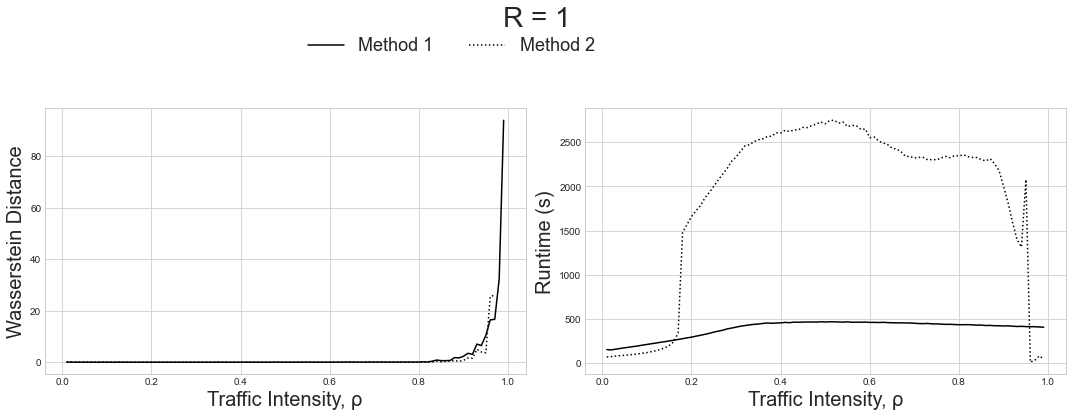

In [14]:
plot_runtime_and_errors(R=1);

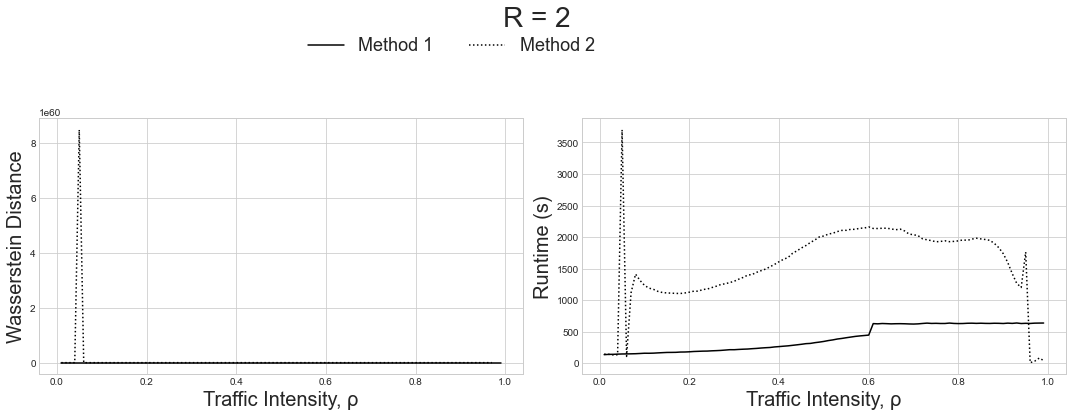

In [15]:
plot_runtime_and_errors(R=2);

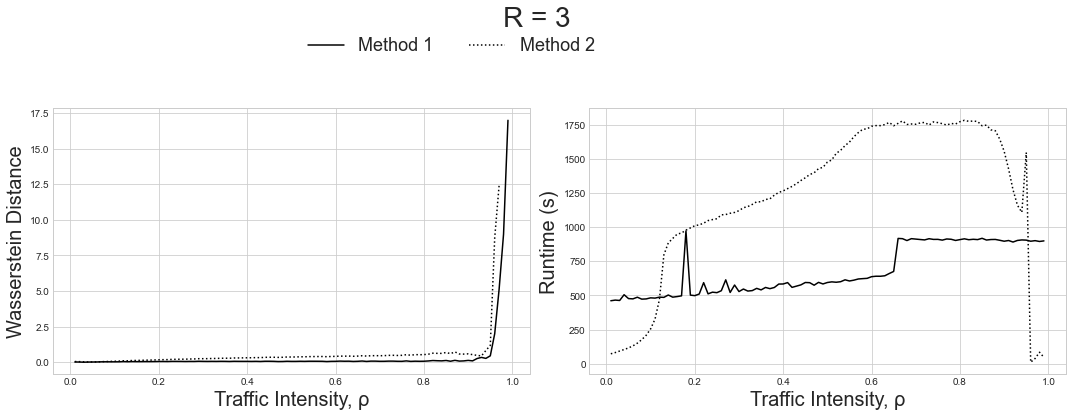

In [16]:
plot_runtime_and_errors(R=3);

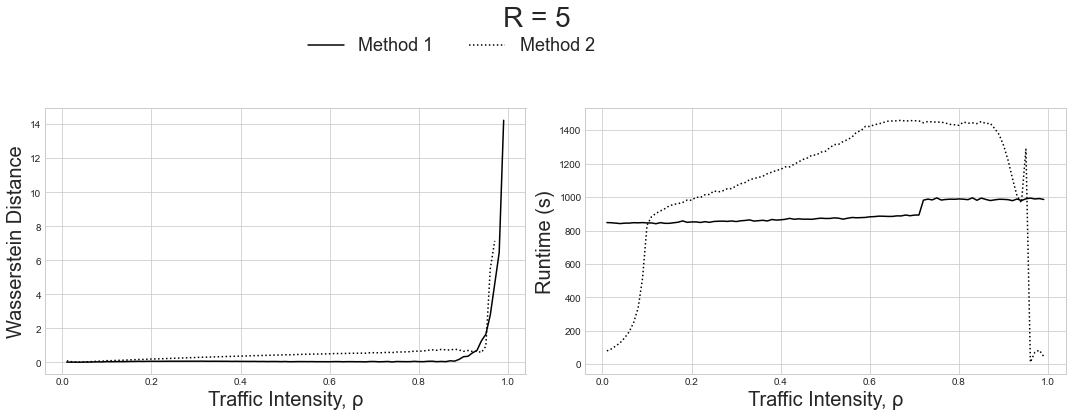

In [17]:
plot_runtime_and_errors(R=5);

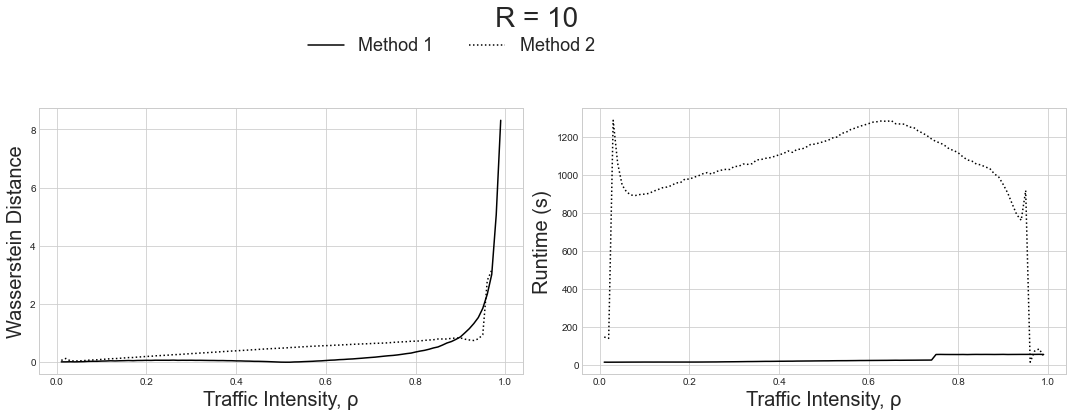

In [18]:
plot_runtime_and_errors(R=10);

+ Note here that runtimes for the simulation are the average runtime per trial.
+ We could sum up the trial runtimes, but that would be highly dependent on the chosen number of trials.
+ Having said that, even for one trial the runtime is highly dependent on the max_simtulation_time.
+ Should we even be reporting simulation runtimes?

# Just looking at Methods 1 and 2 in isolation:

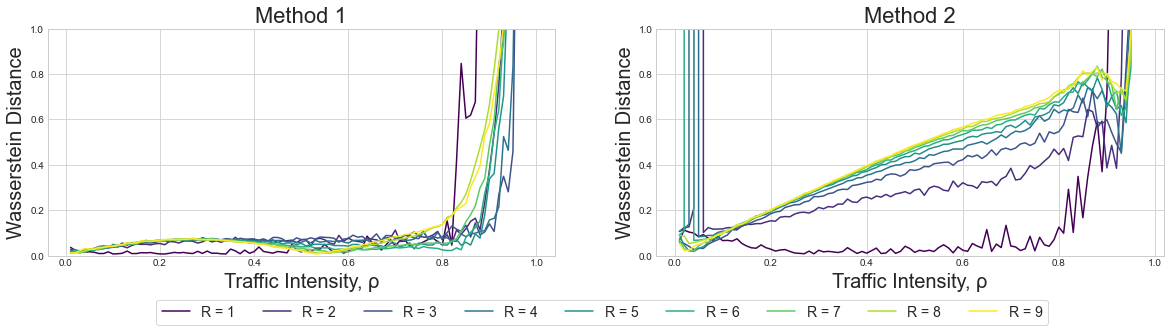

In [26]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
vals = np.linspace(0, 1, 9)
for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m1'], c=col, label=f'R = {R}')
axarr[0].set_ylim(0, 1)
axarr[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[0].set_ylabel('Wasserstein Distance', fontsize=20)
axarr[0].set_title("Method 1", fontsize=22)

for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m2'], c=col)
axarr[1].set_ylim(0, 1)
axarr[1].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[1].set_ylabel('Wasserstein Distance', fontsize=20)
axarr[1].set_title("Method 2", fontsize=22)

axarr[0].legend(fontsize=14, loc='center left', bbox_to_anchor=(0.2, -0.25), ncol=9, frameon=True)
plt.subplots_adjust(bottom=0.25)
plt.savefig('compare_accuracies.pdf')

In [36]:
data[(data['error m2'] > 1)&(data['rho'] < 0.2)]

Unnamed: 0  R   rho   runtime m1   runtime m2  error m1       error m2  \
103         103  2  0.05   149.001608  3700.369684  0.021938   8.470717e+60   
300         300  4  0.04  2506.679587  3617.743527  0.018915  5.602369e+110   
497         497  6  0.03   751.635178  3676.575071  0.017269   2.454394e+59   

              diff  
103  -8.470717e+60  
300 -5.602369e+110  
497  -2.454394e+59

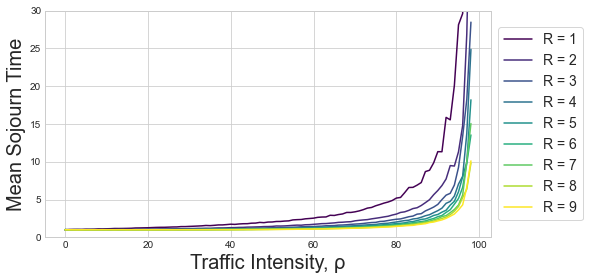

In [27]:
fig, ax = plt.subplots(1, figsize=(8, 5))
vals = np.linspace(0, 1, 9)
for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    ax.plot([simulation_means[(R, round(rho, 2))] for rho in np.linspace(0.01, 0.99, 99)], c=col, label=f'R = {R}')
ax.set_ylim(0, 30)
ax.set_xlabel('Traffic Intensity, ρ', fontsize=20)
ax.set_ylabel('Mean Sojourn Time', fontsize=20)

ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=True)
plt.subplots_adjust(bottom=0.25)
plt.savefig('mean_sojourn_times.pdf')

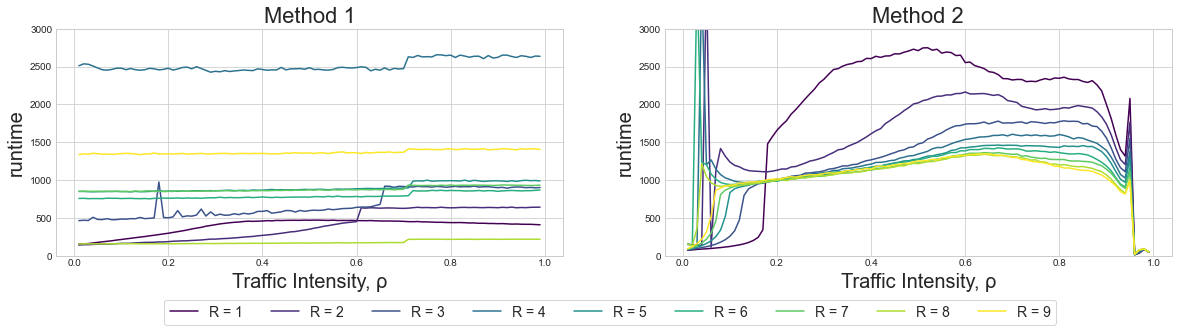

In [28]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
vals = np.linspace(0, 1, 9)
for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m1'], c=col, label=f'R = {R}')
axarr[0].set_ylim(0, 3000)
axarr[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[0].set_ylabel('runtime', fontsize=20)
axarr[0].set_title("Method 1", fontsize=22)

for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m2'], c=col)
axarr[1].set_ylim(0, 3000)
axarr[1].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[1].set_ylabel('runtime', fontsize=20)
axarr[1].set_title("Method 2", fontsize=22)

axarr[0].legend(fontsize=14, loc='center left', bbox_to_anchor=(0.2, -0.25), ncol=9, frameon=True)
plt.subplots_adjust(bottom=0.25)
plt.savefig('compare_runtimes.pdf')

In [29]:
data['diff'] = data['error m1'] - data['error m2']
z = [[data.set_index(['R', 'rho'])['diff'].loc[R, round(rho, 2)] for rho in np.linspace(0.01, 0.99, 99)] for R in range(1, 11)]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if sys.path[0] == '':


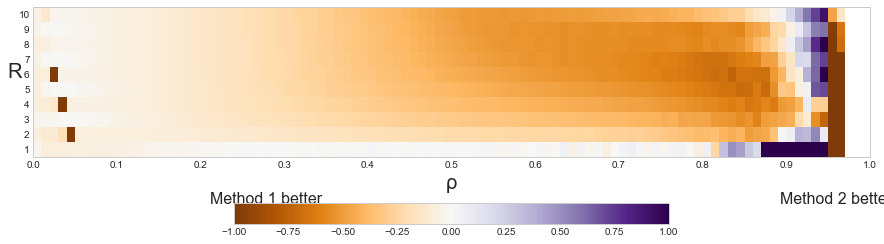

In [30]:
X = [i-0.5 for i in range(99)]
Y = [i-0.5 for i in range(10)]
fig, ax = plt.subplots(1, figsize=(15, 4))
ax.grid(False)
hm = ax.pcolormesh(X, Y, z, cmap='PuOr', vmin=-1, vmax=1)
ax.set_ylabel('R', fontsize=20, rotation=0)
ax.set_xlabel('ρ', fontsize=20)
ax.set_yticks([i-0.5 for i in range(10)])
ax.set_xticks([-1, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99])
ax.set_yticklabels(range(1, 11))
ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar = fig.colorbar(hm, location='bottom', fraction=0.1, pad=0.21)
ax.annotate("Method 1 better", xy=(210, 40), xycoords='figure pixels',fontsize=16)
ax.annotate("Method 2 better", xy=(780, 40), xycoords='figure pixels',fontsize=16)
plt.savefig('compare_accuracies_grid.pdf')